# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.11.0


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [4]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_maf_08_04_lesser_ratio'


print(os.getcwd())

os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu
/home/ubuntu/results/toy_example_maf_08_04_lesser_ratio


In [5]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [6]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [7]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [8]:
samples_prior_list = samples_prior.unsqueeze(0)

In [9]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [10]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


In [11]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [12]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.417
acceptance rate:  0.4284545454545455


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.457
acceptance rate:  0.4278181818181818
tensor([4.8416, 5.1247, 4.5233, 4.0629, 4.7646, 2.1939, 3.0510, 3.1971, 3.9432,
        3.4376, 4.3932, 2.9259, 5.3771, 2.6177, 2.2973])
tensor([ 8.5573, 10.3553, 21.2699,  9.2559, 82.4372, 52.5601, 33.9727, 26.6964,
        10.4731, 66.4719,  8.7061, 64.9811, 89.3433, 41.7447, 46.6048])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[25.0851, 20.4813,  9.0273,  6.6286, 37.8874,  4.0975, 27.3484,  3.4944,
         26.8527, 10.3976, 14.5379,  3.2258, 58.9006,  3.4859,  2.5948]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.048
acceptance rate:  0.039363636363636365
acceptance rate:  0.03942857142857143
acceptance rate:  0.03919354838709677


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.034
acceptance rate:  0.040090909090909094
acceptance rate:  0.039619047619047616
acceptance rate:  0.04051612903225806
tensor([2.8148, 5.5629, 5.4871, 5.3981, 4.5873, 2.8838, 3.8597, 3.3334, 4.0660,
        3.0862, 5.7766, 3.4273, 2.9587, 3.1039, 2.4161])
tensor([ 4.6273, 11.9769, 24.3160, 13.9453, 92.2916, 55.3746, 22.5445, 27.6074,
         8.5332, 70.1322, 12.2735, 62.8545, 96.0090, 42.3072, 48.5694])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.7506, 31.1182, 22.1658, 20.1664, 11.1239,  2.6692, 15.5239,  4.0361,
         16.6384,  3.1442, 40.8824,  9.0887,  7.2652,  5.8461,  7.9067]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.037
acceptance rate:  0.02881818181818182
acceptance rate:  0.028857142857142856
acceptance rate:  0.028516129032258065
acceptance rate:  0.027585365853658537


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.039
acceptance rate:  0.028727272727272726
acceptance rate:  0.028285714285714286
acceptance rate:  0.0272258064516129
acceptance rate:  0.02675609756097561
tensor([2.3536, 3.6361, 3.1947, 4.5593, 3.4410, 2.0478, 2.9613, 2.9857, 3.6169,
        2.1993, 4.3374, 2.7343, 3.5972, 1.6952, 2.4933])
tensor([ 3.9449,  7.1376, 22.6580, 12.0386, 94.1194, 56.9393, 27.6795, 27.9714,
        11.9832, 66.1037, 10.3851, 63.9738, 94.9944, 38.2586, 45.4875])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.8602,  5.4667,  6.9739, 10.4546, 12.6689,  2.7605,  3.0299,  3.3353,
         36.6210,  8.7209, 21.9388,  4.2850, 12.7122,  1.9252,  1.8135]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.129
acceptance rate:  0.1368181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.155
acceptance rate:  0.1409090909090909
tensor([3.7677, 3.0757, 2.5787, 4.8899, 2.8683, 1.7384, 3.9030, 3.1240, 3.6746,
        2.3861, 3.7762, 2.5271, 3.3699, 2.6916, 2.7866])
tensor([ 7.1809,  5.6161, 21.5323, 18.0148, 88.3263, 55.8854, 24.1530, 32.5817,
         8.5795, 67.1824,  9.1656, 64.7190, 95.3039, 38.4643, 46.7365])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[14.0111,  3.1800,  3.0515, 41.9869,  3.9604,  0.8501,  9.8078, 18.8182,
         15.4358,  5.4465, 13.9771,  2.5865, 10.7937,  3.3114,  3.8654]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.247
acceptance rate:  0.25672727272727275


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.255
acceptance rate:  0.25545454545454543
tensor([4.5110, 4.7062, 3.5400, 3.8515, 3.9258, 2.0072, 3.2045, 2.7122, 4.7533,
        3.2492, 5.6315, 3.0135, 5.1849, 2.5219, 2.5271])
tensor([ 8.2001, 11.7389, 20.3010, 17.4247, 89.3106, 55.5130, 29.0189, 26.3263,
        10.7598, 62.1476, 16.3973, 66.7686, 93.1815, 43.1573, 46.1215])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[21.6885, 25.4930,  4.5469, 33.1315,  6.0761,  0.9492,  5.5077,  2.4072,
         32.0853, 34.4301, 78.5779,  3.2329, 28.2235,  6.7391,  2.3949]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.199
acceptance rate:  0.21036363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.214
acceptance rate:  0.21236363636363637
tensor([4.2065, 3.9692, 2.8555, 4.2657, 3.1736, 2.9367, 4.2374, 2.9037, 4.1621,
        4.3478, 4.5920, 2.9135, 4.4465, 2.3463, 2.2463])
tensor([ 6.9572,  7.3005, 22.0940, 10.3880, 89.2049, 52.4508, 33.0301, 30.9098,
         9.1882, 66.1050, 12.0994, 63.0524, 92.4635, 41.6528, 44.6343])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[14.7403,  6.8446,  4.7200,  7.2227,  3.6972,  5.9841, 25.2151, 10.2932,
         20.1942, 15.0675, 33.7200,  7.0190, 29.2563,  2.7655,  1.2806]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.043
acceptance rate:  0.05118181818181818
acceptance rate:  0.05104761904761905


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.036
acceptance rate:  0.04672727272727273
acceptance rate:  0.04642857142857143
acceptance rate:  0.04670967741935484
tensor([4.2946, 4.2491, 3.6465, 4.8954, 5.2493, 2.9659, 4.5855, 3.2953, 5.0798,
        2.3536, 5.5046, 3.4599, 3.4115, 3.1143, 2.5780])
tensor([ 7.1337,  7.6891, 21.2692, 10.0307, 86.9417, 55.3447, 29.5329, 30.6391,
        10.1747, 67.9208,  9.4123, 60.0547, 95.3357, 38.6077, 46.2765])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[15.8083,  8.5074,  5.6601,  9.8948, 16.2961,  2.8704, 11.6985, 10.3585,
         29.8407,  3.5754, 22.6786, 21.9178, 10.8053,  4.1827,  2.6908]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.009


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 891 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.009909090909090909
acceptance rate:  0.009952380952380952
acceptance rate:  0.010387096774193548
acceptance rate:  0.010853658536585365
acceptance rate:  0.010607843137254902
acceptance rate:  0.010032786885245901
acceptance rate:  0.009943661971830987
acceptance rate:  0.009814814814814814
acceptance rate:  0.009846153846153846
acceptance rate:  0.009831683168316832
acceptance rate:  0.00981081081081081


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.011


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 897 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.009363636363636364
acceptance rate:  0.01
acceptance rate:  0.009645161290322581
acceptance rate:  0.009926829268292683
acceptance rate:  0.00996078431372549
acceptance rate:  0.01001639344262295
acceptance rate:  0.009788732394366197
acceptance rate:  0.009790123456790123
acceptance rate:  0.009703296703296704
acceptance rate:  0.009762376237623762
acceptance rate:  0.009774774774774776
tensor([3.5257, 6.0330, 4.1082, 4.7982, 5.2452, 2.2621, 3.7877, 3.5296, 3.6767,
        3.5879, 5.1757, 3.0810, 2.9333, 2.9602, 3.1185])
tensor([ 5.9372, 13.4402, 26.2679, 12.0275, 91.6569, 58.5513, 26.7493, 23.8471,
         6.2325, 76.2262,  8.6529, 61.3651, 95.9763, 42.0541, 44.3580])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 8.7687, 43.5795, 26.1690, 11.4985, 12.9712,  7.5480,  5.3731,  9.4383,
          7.4491, 24.0416, 17.9218, 13.8619,  7.2974,

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.388
acceptance rate:  0.40454545454545454


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.424
acceptance rate:  0.40354545454545454
tensor([3.1387, 4.4558, 3.4853, 3.0305, 4.6372, 1.9906, 3.4548, 2.2819, 4.6832,
        2.4135, 3.7610, 2.8924, 5.7619, 2.0514, 2.0982])
tensor([ 5.9235, 10.4689, 22.0422, 12.9458, 85.3797, 56.8847, 30.9266, 30.2006,
        10.2661, 66.4198,  7.1538, 64.9083, 89.2380, 39.6781, 47.0001])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 7.5554, 17.9183,  6.4104,  7.3222, 19.3915,  2.5689, 11.9372,  6.4006,
         28.5544,  7.9404,  7.5671,  3.2167, 61.9968,  0.9374,  2.9603]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.347
acceptance rate:  0.33445454545454545


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.327
acceptance rate:  0.3300909090909091
tensor([3.3847, 3.2093, 3.2038, 3.4452, 4.2376, 2.2193, 2.8576, 2.7593, 4.0072,
        2.8573, 7.3770, 4.0498, 3.6085, 2.3770, 1.9739])
tensor([ 9.1380,  7.1637, 21.5618, 11.9565, 87.9846, 54.4026, 25.4598, 29.1903,
         8.7180, 67.8120, 15.2632, 63.1367, 94.9845, 38.7799, 46.4262])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[22.8464,  4.1608,  4.6874,  6.1116,  9.0657,  1.3439,  3.7191,  4.6905,
         17.2704,  4.9260, 77.3783, 10.4013, 12.7896,  2.2035,  1.7851]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.229
acceptance rate:  0.23572727272727273


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.235
acceptance rate:  0.2399090909090909
tensor([3.6777, 3.6809, 3.9551, 5.1162, 3.7039, 2.7914, 3.5672, 3.4166, 3.9636,
        2.5120, 3.6267, 2.7372, 3.6740, 2.5156, 2.2238])
tensor([ 9.1974,  7.9069, 21.0130, 11.6258, 90.4256, 57.8521, 29.4106, 25.9171,
         7.8609, 69.4909,  6.3103, 61.6538, 94.6482, 37.0950, 43.7252])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[24.1645,  6.7895,  6.4596, 12.2768,  5.1408,  6.4365,  7.4960,  4.6944,
         13.4311,  1.8637,  5.6466, 11.6838, 14.4172,  5.9613,  1.9859]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 998 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0001818181818181818
acceptance rate:  9.523809523809524e-05
acceptance rate:  6.451612903225807e-05
acceptance rate:  7.317073170731707e-05
acceptance rate:  9.80392156862745e-05
acceptance rate:  8.19672131147541e-05
acceptance rate:  7.042253521126761e-05
acceptance rate:  6.17283950617284e-05
acceptance rate:  6.593406593406593e-05
acceptance rate:  6.93069306930693e-05
acceptance rate:  6.306306306306306e-05
acceptance rate:  7.43801652892562e-05
acceptance rate:  6.870229007633588e-05
acceptance rate:  7.801418439716312e-05
acceptance rate:  7.947019867549669e-05
acceptance rate:  8.074534161490683e-05
acceptance rate:  7.602339181286549e-05
acceptance rate:  7.18232044198895e-05
acceptance rate:  7.329842931937172e-05
acceptance rate:  7.960199004975125e-05
acceptance rate:  7.582938388625592e-05
acceptance rate:  7.239819004524887e-05
acceptance rate:  7.35930735930736e-05
acceptance rate:  7.053941908713692e-05
acceptance rate:  7.171314741035856e-05
accepta

acceptance rate:  7.098020280057943e-05
acceptance rate:  7.111965401249399e-05
acceptance rate:  7.125777140124342e-05
acceptance rate:  7.139457401237505e-05
acceptance rate:  7.105637138796779e-05
acceptance rate:  7.166430928807166e-05
acceptance rate:  7.179727827311121e-05
acceptance rate:  7.192900513778608e-05
acceptance rate:  7.205950720595072e-05
acceptance rate:  7.172605275335493e-05
acceptance rate:  7.18562874251497e-05
acceptance rate:  7.152682255845942e-05
acceptance rate:  7.120036513007759e-05
acceptance rate:  7.087687414811449e-05
acceptance rate:  7.055630936227951e-05
acceptance rate:  7.023863124718595e-05
acceptance rate:  7.082025997310622e-05
acceptance rate:  7.050423917893797e-05
acceptance rate:  7.107952021323856e-05
acceptance rate:  7.076514816452896e-05
acceptance rate:  7.045354469396742e-05
acceptance rate:  7.014467338886454e-05
acceptance rate:  6.983849847228285e-05
acceptance rate:  6.953498478922208e-05
acceptance rate:  7.009952401557767e-05
a

acceptance rate:  7.020091987412248e-05
acceptance rate:  7.003139338324076e-05
acceptance rate:  7.010358949650687e-05
acceptance rate:  7.041576544099976e-05
acceptance rate:  7.024694317909374e-05
acceptance rate:  7.007892848600813e-05
acceptance rate:  7.015032211882605e-05
acceptance rate:  6.998333730064271e-05
acceptance rate:  7.076703870814534e-05
acceptance rate:  7.107320540156361e-05
acceptance rate:  7.11415740959584e-05
acceptance rate:  7.097382692761141e-05
acceptance rate:  7.104210773935544e-05
acceptance rate:  7.111006805914105e-05
acceptance rate:  7.094357293373918e-05
acceptance rate:  7.101144592384956e-05
acceptance rate:  7.13120484735493e-05
acceptance rate:  7.184375726575215e-05
acceptance rate:  7.214103456274646e-05
acceptance rate:  7.197408007405694e-05
acceptance rate:  7.180789655968599e-05
acceptance rate:  7.210320202718267e-05
acceptance rate:  7.216731785796369e-05
acceptance rate:  7.200183444164182e-05
acceptance rate:  7.206588881262869e-05
ac

acceptance rate:  7.268615732514941e-05
acceptance rate:  7.27302048056765e-05
acceptance rate:  7.277411044920302e-05
acceptance rate:  7.265712907892622e-05
acceptance rate:  7.254052319049912e-05
acceptance rate:  7.258452171126422e-05
acceptance rate:  7.262837945928651e-05
acceptance rate:  7.267209710908801e-05
acceptance rate:  7.271567533088821e-05
acceptance rate:  7.275911479063843e-05
acceptance rate:  7.264345890955333e-05
acceptance rate:  7.268687509919061e-05
acceptance rate:  7.273015369988908e-05
acceptance rate:  7.261509254864737e-05
acceptance rate:  7.281630074237877e-05
acceptance rate:  7.27014666456395e-05
acceptance rate:  7.25869941741458e-05
acceptance rate:  7.263008960855212e-05
acceptance rate:  7.251608852613405e-05
acceptance rate:  7.25591600062686e-05
acceptance rate:  7.244562666249413e-05
acceptance rate:  7.2488673644743e-05
acceptance rate:  7.237560442988613e-05
acceptance rate:  7.257436536365052e-05
acceptance rate:  7.26170113512673e-05
accepta

acceptance rate:  7.259726093806812e-05
acceptance rate:  7.26304321510713e-05
acceptance rate:  7.254261878853827e-05
acceptance rate:  7.245501750996257e-05
acceptance rate:  7.248824026052346e-05
acceptance rate:  7.252138296590772e-05
acceptance rate:  7.243412345084828e-05
acceptance rate:  7.234707366903016e-05
acceptance rate:  7.250030008402352e-05
acceptance rate:  7.253326939215922e-05
acceptance rate:  7.256615974134835e-05
acceptance rate:  7.247936849659132e-05
acceptance rate:  7.251224465416318e-05
acceptance rate:  7.254504235771387e-05
acceptance rate:  7.257776188773687e-05
acceptance rate:  7.249137007499107e-05
acceptance rate:  7.240518368802758e-05
acceptance rate:  7.243795273720461e-05
acceptance rate:  7.235203415964892e-05
acceptance rate:  7.226631915649804e-05
acceptance rate:  7.218080700508815e-05
acceptance rate:  7.233187566481503e-05
acceptance rate:  7.248258765198914e-05
acceptance rate:  7.239712298078057e-05
acceptance rate:  7.254740313272877e-05
a

acceptance rate:  7.167103093783338e-05
acceptance rate:  7.179536866582695e-05
acceptance rate:  7.191946568580002e-05
acceptance rate:  7.194662024949232e-05
acceptance rate:  7.187711332238432e-05
acceptance rate:  7.190425634591255e-05
acceptance rate:  7.183492430816701e-05
acceptance rate:  7.195838551199306e-05
acceptance rate:  7.198537195650082e-05
acceptance rate:  7.201230650898952e-05
acceptance rate:  7.19431370665642e-05
acceptance rate:  7.187410037424431e-05
acceptance rate:  7.19010641357492e-05
acceptance rate:  7.2023752514127e-05
acceptance rate:  7.195483685771696e-05
acceptance rate:  7.188605295860816e-05
acceptance rate:  7.191290230159488e-05
acceptance rate:  7.18442896670165e-05
acceptance rate:  7.196644743113145e-05
acceptance rate:  7.208837253594895e-05
acceptance rate:  7.201978879269337e-05
acceptance rate:  7.195133542438932e-05
acceptance rate:  7.188301205963346e-05
acceptance rate:  7.181481832843183e-05
acceptance rate:  7.184153160837835e-05
accep

acceptance rate:  7.210411446123999e-05
acceptance rate:  7.212664566674744e-05
acceptance rate:  7.214914050520539e-05
acceptance rate:  7.217159906459156e-05
acceptance rate:  7.211344774796551e-05
acceptance rate:  7.205539006521215e-05
acceptance rate:  7.19974257903628e-05
acceptance rate:  7.193955469817539e-05
acceptance rate:  7.196209139828126e-05
acceptance rate:  7.190434154562235e-05
acceptance rate:  7.192687033918691e-05
acceptance rate:  7.186924124669497e-05
acceptance rate:  7.189176206868945e-05
acceptance rate:  7.20742340612751e-05
acceptance rate:  7.201662536967469e-05
acceptance rate:  7.2118840348215e-05
acceptance rate:  7.214109009656053e-05
acceptance rate:  7.216330436169365e-05
acceptance rate:  7.218548322842802e-05
acceptance rate:  7.212801528540722e-05
acceptance rate:  7.207063877177631e-05
acceptance rate:  7.209283840712185e-05
acceptance rate:  7.203558097053451e-05
acceptance rate:  7.205777319260377e-05
acceptance rate:  7.207993021964952e-05
acce

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 998 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0001818181818181818
acceptance rate:  9.523809523809524e-05
acceptance rate:  6.451612903225807e-05
acceptance rate:  4.878048780487805e-05
acceptance rate:  7.843137254901961e-05
acceptance rate:  9.836065573770491e-05
acceptance rate:  9.859154929577464e-05
acceptance rate:  8.641975308641975e-05
acceptance rate:  7.692307692307693e-05
acceptance rate:  6.93069306930693e-05
acceptance rate:  6.306306306306306e-05
acceptance rate:  5.785123966942149e-05
acceptance rate:  6.106870229007633e-05
acceptance rate:  7.092198581560284e-05
acceptance rate:  7.284768211920529e-05
acceptance rate:  7.453416149068323e-05
acceptance rate:  7.017543859649122e-05
acceptance rate:  7.18232044198895e-05
acceptance rate:  7.329842931937172e-05
acceptance rate:  6.965174129353234e-05
acceptance rate:  6.635071090047393e-05
acceptance rate:  7.239819004524887e-05
acceptance rate:  6.926406926406926e-05
acceptance rate:  7.053941908713692e-05
acceptance rate:  6.772908366533864e-05
ac

acceptance rate:  8.015451472718494e-05
acceptance rate:  8.024987986544931e-05
acceptance rate:  8.034433285509326e-05
acceptance rate:  8.043788672060923e-05
acceptance rate:  8.053055423969682e-05
acceptance rate:  8.015087223008015e-05
acceptance rate:  7.977475363679023e-05
acceptance rate:  7.940214852872489e-05
acceptance rate:  7.949790794979079e-05
acceptance rate:  7.959278111985193e-05
acceptance rate:  8.060801473975126e-05
acceptance rate:  8.161393856029344e-05
acceptance rate:  8.124144226380649e-05
acceptance rate:  8.132666969559291e-05
acceptance rate:  8.186341022161918e-05
acceptance rate:  8.14948221521837e-05
acceptance rate:  8.11295383236217e-05
acceptance rate:  8.076751450245427e-05
acceptance rate:  8.040870724122612e-05
acceptance rate:  8.00530738611234e-05
acceptance rate:  7.970057243505064e-05
acceptance rate:  7.978956597983341e-05
acceptance rate:  7.944129201222174e-05
acceptance rate:  7.909604519774011e-05
acceptance rate:  7.875378623972306e-05
acc

acceptance rate:  7.552650689905591e-05
acceptance rate:  7.558560734122193e-05
acceptance rate:  7.564442303059503e-05
acceptance rate:  7.594328286469598e-05
acceptance rate:  7.576120834332295e-05
acceptance rate:  7.55800047835446e-05
acceptance rate:  7.587687902648533e-05
acceptance rate:  7.569626279457273e-05
acceptance rate:  7.551650439325576e-05
acceptance rate:  7.533759772565742e-05
acceptance rate:  7.515953675254077e-05
acceptance rate:  7.498231549162933e-05
acceptance rate:  7.48059280169372e-05
acceptance rate:  7.486505515137291e-05
acceptance rate:  7.492390540856942e-05
acceptance rate:  7.498248072880168e-05
acceptance rate:  7.504078303425775e-05
acceptance rate:  7.509881422924901e-05
acceptance rate:  7.515657620041754e-05
acceptance rate:  7.498264290673456e-05
acceptance rate:  7.480951281459248e-05
acceptance rate:  7.486754204100438e-05
acceptance rate:  7.561480119512756e-05
acceptance rate:  7.544141252006421e-05
acceptance rate:  7.526881720430108e-05
ac

acceptance rate:  7.656275238249072e-05
acceptance rate:  7.676181261086921e-05
acceptance rate:  7.663822250845275e-05
acceptance rate:  7.69972673203665e-05
acceptance rate:  7.70341839191141e-05
acceptance rate:  7.691075148213427e-05
acceptance rate:  7.726763717805151e-05
acceptance rate:  7.73039450567002e-05
acceptance rate:  7.718067293892521e-05
acceptance rate:  7.737621397866581e-05
acceptance rate:  7.725321888412017e-05
acceptance rate:  7.713061418822409e-05
acceptance rate:  7.700839803517667e-05
acceptance rate:  7.688656858092074e-05
acceptance rate:  7.676512399305007e-05
acceptance rate:  7.680176628292067e-05
acceptance rate:  7.66808376633601e-05
acceptance rate:  7.671749724886024e-05
acceptance rate:  7.659708052111129e-05
acceptance rate:  7.647704121611032e-05
acceptance rate:  7.667031763417306e-05
acceptance rate:  7.655053897828464e-05
acceptance rate:  7.689907970675401e-05
acceptance rate:  7.677931786326118e-05
acceptance rate:  7.681542528378168e-05
acce

acceptance rate:  7.3082050660526e-05
acceptance rate:  7.311463503207844e-05
acceptance rate:  7.314714061177608e-05
acceptance rate:  7.317956768506219e-05
acceptance rate:  7.309130382342299e-05
acceptance rate:  7.312372003373088e-05
acceptance rate:  7.315605823607268e-05
acceptance rate:  7.318831871169331e-05
acceptance rate:  7.31004681310767e-05
acceptance rate:  7.301282819805778e-05
acceptance rate:  7.304514429409652e-05
acceptance rate:  7.295778016983615e-05
acceptance rate:  7.287062477601242e-05
acceptance rate:  7.302231237322515e-05
acceptance rate:  7.305446311524252e-05
acceptance rate:  7.308653731698607e-05
acceptance rate:  7.299964332421829e-05
acceptance rate:  7.291295570597316e-05
acceptance rate:  7.29450836199739e-05
acceptance rate:  7.285866603483e-05
acceptance rate:  7.277245296414625e-05
acceptance rate:  7.268644368277981e-05
acceptance rate:  7.27186872860347e-05
acceptance rate:  7.275085485202217e-05
acceptance rate:  7.278294664939347e-05
acceptan

acceptance rate:  7.227981784710784e-05
acceptance rate:  7.230664988868454e-05
acceptance rate:  7.233343003577991e-05
acceptance rate:  7.226354941551541e-05
acceptance rate:  7.238683524756298e-05
acceptance rate:  7.25098833285122e-05
acceptance rate:  7.244003467874e-05
acceptance rate:  7.256279472620536e-05
acceptance rate:  7.249302951639265e-05
acceptance rate:  7.271155508596676e-05
acceptance rate:  7.264178101909606e-05
acceptance rate:  7.266800881986387e-05
acceptance rate:  7.259841011397376e-05
acceptance rate:  7.272031384556502e-05
acceptance rate:  7.274639135837874e-05
acceptance rate:  7.26769171998854e-05
acceptance rate:  7.260757561301403e-05
acceptance rate:  7.263368601658564e-05
acceptance rate:  7.256451766498429e-05
acceptance rate:  7.259061935115593e-05
acceptance rate:  7.280676741754586e-05
acceptance rate:  7.273763175386953e-05
acceptance rate:  7.266862726496537e-05
acceptance rate:  7.259975357785992e-05
acceptance rate:  7.262569832402235e-05
accep

acceptance rate:  7.123818754543252e-05
acceptance rate:  7.126139940279235e-05
acceptance rate:  7.120393516651882e-05
acceptance rate:  7.114656353235034e-05
acceptance rate:  7.116979309234361e-05
acceptance rate:  7.111254122757622e-05
acceptance rate:  7.113576079093321e-05
acceptance rate:  7.11589430567826e-05
acceptance rate:  7.110183773372924e-05
acceptance rate:  7.112501002325395e-05
acceptance rate:  7.114814518067463e-05
acceptance rate:  7.117124329517253e-05
acceptance rate:  7.111431085513159e-05
acceptance rate:  7.113739908880185e-05
acceptance rate:  7.108058461784203e-05
acceptance rate:  7.102386082515362e-05
acceptance rate:  7.112670440953672e-05
acceptance rate:  7.1149709186519e-05
acceptance rate:  7.10930658387071e-05
acceptance rate:  7.111606077479914e-05
acceptance rate:  7.121850409347429e-05
acceptance rate:  7.116194106901756e-05
acceptance rate:  7.118482660106341e-05
acceptance rate:  7.112837998572675e-05
acceptance rate:  7.115125584343555e-05
acce

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.05
acceptance rate:  0.04890909090909091
acceptance rate:  0.047619047619047616


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.056
acceptance rate:  0.048363636363636366
acceptance rate:  0.04623809523809524
acceptance rate:  0.046129032258064515
tensor([3.7406, 4.3417, 4.0656, 3.6813, 3.7630, 2.9075, 3.6977, 2.9507, 5.0698,
        3.4561, 4.1782, 2.5515, 2.9110, 2.7450, 2.7501])
tensor([ 6.7793, 12.5792, 25.1630,  8.5455, 88.5587, 53.6877, 23.6608, 28.2318,
        10.1154, 69.6733,  7.6500, 63.3992, 96.3392, 42.4188, 43.8833])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[12.3185, 29.1000, 19.6902,  6.0304,  6.2935,  3.5205, 10.6040,  3.5298,
         29.4272,  4.2856, 10.3100,  5.2005,  6.2084,  5.1829,  2.8934]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.364
acceptance rate:  0.37154545454545457


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.397
acceptance rate:  0.3891818181818182
tensor([3.7795, 6.1197, 4.1579, 4.0637, 4.3763, 2.5238, 2.7309, 3.0553, 3.6425,
        2.5998, 5.0642, 3.6495, 5.8723, 2.4685, 2.9327])
tensor([ 7.7001, 14.4666, 24.1547, 10.6542, 88.7977, 55.5703, 28.1275, 32.1532,
         7.4004, 66.8612,  9.9567, 62.6538, 89.3549, 41.8277, 48.9031])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[16.3581, 52.2556, 15.3497,  6.5687,  8.3225,  1.9216,  2.8599, 16.3282,
         10.6226,  6.8502, 22.9856, 10.4633, 61.4856,  3.3134, 10.3413]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.002


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 993 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0006363636363636364
acceptance rate:  0.0004761904761904762
acceptance rate:  0.00041935483870967743
acceptance rate:  0.00036585365853658537
acceptance rate:  0.00035294117647058826
acceptance rate:  0.0004098360655737705
acceptance rate:  0.0004084507042253521
acceptance rate:  0.0004197530864197531
acceptance rate:  0.00045054945054945057
acceptance rate:  0.00045544554455445547
acceptance rate:  0.0004684684684684685
acceptance rate:  0.00045454545454545455
acceptance rate:  0.0004885496183206107
acceptance rate:  0.0004893617021276596
acceptance rate:  0.00048344370860927153
acceptance rate:  0.000484472049689441
acceptance rate:  0.0004970760233918128
acceptance rate:  0.0005027624309392265
acceptance rate:  0.0004973821989528796
acceptance rate:  0.0004975124378109452
acceptance rate:  0.0004928909952606635
acceptance rate:  0.0004841628959276018
acceptance rate:  0.00048484848484848484
acceptance rate:  0.0004730290456431535
acceptance rate:  0.0004741035856

acceptance rate:  0.0004641638225255973
acceptance rate:  0.0004643377001455604
acceptance rate:  0.0004649927571221632
acceptance rate:  0.0004651609802979337
acceptance rate:  0.0004643711142993783
acceptance rate:  0.00046311280342693957
acceptance rate:  0.00046281383230696355
acceptance rate:  0.0004625176803394625
acceptance rate:  0.0004622243078366964
acceptance rate:  0.00046146660439047176
acceptance rate:  0.00046164574616457463
acceptance rate:  0.00046182322998611754
acceptance rate:  0.0004610778443113772


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.002


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 994 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0005454545454545455
acceptance rate:  0.0005238095238095238
acceptance rate:  0.0004838709677419355
acceptance rate:  0.00046341463414634144
acceptance rate:  0.0004901960784313725
acceptance rate:  0.00042622950819672133
acceptance rate:  0.0004788732394366197
acceptance rate:  0.0004691358024691358
acceptance rate:  0.0004835164835164835
acceptance rate:  0.00048514851485148515
acceptance rate:  0.0005135135135135136
acceptance rate:  0.0005041322314049587
acceptance rate:  0.0004885496183206107
acceptance rate:  0.0004893617021276596
acceptance rate:  0.0004900662251655629
acceptance rate:  0.0004658385093167702
acceptance rate:  0.00047368421052631577
acceptance rate:  0.0004917127071823205
acceptance rate:  0.0004973821989528796
acceptance rate:  0.0004975124378109452
acceptance rate:  0.00047393364928909954
acceptance rate:  0.00047963800904977374
acceptance rate:  0.00048484848484848484
acceptance rate:  0.0004771784232365145
acceptance rate:  0.0004701195219

acceptance rate:  0.0004762371386575208
acceptance rate:  0.0004763529985372989
acceptance rate:  0.0004759825327510917
acceptance rate:  0.00047464992757122166
acceptance rate:  0.0004747717443536761
acceptance rate:  0.00047393591582974655
acceptance rate:  0.00047358400761542124
acceptance rate:  0.0004718143060161061
acceptance rate:  0.00047241867043847243
tensor([3.1995, 5.8737, 4.2382, 2.3734, 3.8417, 2.2112, 3.6452, 3.1509, 2.4210,
        2.6591, 3.9996, 2.9924, 4.0040, 3.2399, 2.4748])
tensor([ 4.9802, 11.6526, 20.3191,  3.9906, 91.8103, 57.3332, 30.1123, 24.5222,
         4.0290, 67.2066,  7.1410, 65.2676, 94.8588, 40.1497, 46.8415])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 5.4162, 30.9556,  7.0878, 19.5085,  7.1719,  3.8732,  9.6936,  6.3862,
          1.5468,  5.9588,  8.4042,  3.1494, 14.7031,  3.5841,  3.3518]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.205
acceptance rate:  0.22590909090909092


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.224
acceptance rate:  0.22754545454545455
tensor([4.5339, 3.3117, 2.6042, 3.2650, 3.9244, 1.8867, 3.0852, 3.1116, 3.9021,
        2.8045, 3.4228, 2.7736, 3.8459, 2.1772, 1.7105])
tensor([ 9.4634,  6.0273, 17.7782,  9.0312, 85.2577, 55.0624, 28.5913, 29.1025,
         8.2008, 67.3190,  6.4820, 61.2408, 94.3832, 39.2731, 47.2715])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[29.1542,  3.7866,  4.4021,  4.1162, 17.0779,  0.6469,  4.3986,  5.4162,
         14.5751,  5.9951,  5.2254, 13.6509, 16.2061,  1.3562,  3.0060]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.233
acceptance rate:  0.24172727272727274


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.248
acceptance rate:  0.24427272727272728
tensor([3.7964, 3.7915, 2.8933, 3.4113, 4.2061, 1.9439, 3.2856, 2.5992, 3.2381,
        3.2792, 3.3292, 2.0604, 5.2120, 2.1781, 1.6522])
tensor([ 8.2454,  7.6301, 21.8631,  8.8354, 87.5074, 53.3301, 28.4215, 27.7225,
         6.0646, 65.4622,  6.7949, 62.8053, 92.7197, 41.0140, 44.7104])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[19.1297,  6.6838,  4.3587,  4.7696, 10.0156,  2.1190,  4.7184,  2.1837,
          5.6988, 13.9849,  5.4497,  6.0028, 31.1528,  1.6077,  0.4047]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.01


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 917 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.007545454545454545
acceptance rate:  0.007380952380952381
acceptance rate:  0.007483870967741935
acceptance rate:  0.007536585365853658
acceptance rate:  0.007647058823529412
acceptance rate:  0.007852459016393443
acceptance rate:  0.007901408450704226
acceptance rate:  0.007901234567901235
acceptance rate:  0.008032967032967032
acceptance rate:  0.00808910891089109
acceptance rate:  0.007945945945945946
acceptance rate:  0.007958677685950414
acceptance rate:  0.008030534351145039


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.01


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 912 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008
acceptance rate:  0.007238095238095238
acceptance rate:  0.007419354838709678
acceptance rate:  0.007292682926829269
acceptance rate:  0.007588235294117647
acceptance rate:  0.007524590163934426
acceptance rate:  0.007408450704225352
acceptance rate:  0.007481481481481481
acceptance rate:  0.007494505494505494
acceptance rate:  0.0076336633663366335
acceptance rate:  0.007774774774774775
acceptance rate:  0.00768595041322314
acceptance rate:  0.007770992366412214
tensor([2.7956, 2.5148, 2.7222, 2.4180, 2.4441, 0.9595, 1.9313, 1.9622, 3.0292,
        2.0687, 2.4440, 1.4605, 1.1510, 1.4934, 2.4407])
tensor([ 5.7110,  8.8353, 24.0936, 13.9879, 96.5403, 54.8087, 25.3969, 27.0633,
         6.5381, 66.8110,  4.5215, 64.0761, 98.6617, 36.8580, 51.6740])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[6.0545e+00, 5.7593e+00, 1.0583e+01, 9.4922e+

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.13
acceptance rate:  0.11745454545454545


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.121
acceptance rate:  0.115
tensor([3.6551, 4.3092, 3.5187, 4.7410, 5.1080, 2.1701, 3.3647, 4.8261, 4.5896,
        3.4433, 4.3519, 3.1099, 4.0911, 2.8626, 2.4538])
tensor([ 7.9486,  8.3837, 22.4485, 11.3610, 82.1096, 55.6399, 28.4728, 26.5531,
         9.6569, 64.2923,  7.9236, 64.6305, 94.5003, 40.9414, 46.0763])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[17.1283, 10.1648,  7.4299, 10.1082, 42.0440,  1.2846,  5.0319,  9.6715,
         24.5085, 20.4809, 11.7727,  4.1389, 16.5835,  2.9886,  2.1922]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.056
acceptance rate:  0.06190909090909091
acceptance rate:  0.06157142857142857


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.064
acceptance rate:  0.06272727272727273
acceptance rate:  0.06428571428571428
tensor([4.5704, 4.2473, 3.5579, 4.9979, 3.8049, 2.6347, 2.8296, 3.1351, 3.9637,
        3.3297, 3.3050, 3.1949, 3.3412, 2.3263, 3.6685])
tensor([11.5819,  8.1622, 23.6825, 10.0365, 89.7531, 57.0790, 24.6921, 29.8692,
         6.9583, 66.6048,  6.1831, 65.4741, 95.5351, 40.3579, 43.7595])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[45.2493,  9.4112, 11.3404, 10.3812,  5.4329,  4.1630,  5.1262,  7.3879,
         10.3539,  9.6042,  4.4659,  3.5805,  9.8784,  1.4256,  5.6987]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.063
acceptance rate:  0.058272727272727275
acceptance rate:  0.06085714285714286


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.056
acceptance rate:  0.05690909090909091
acceptance rate:  0.05614285714285714
tensor([3.0007, 3.5311, 3.3221, 3.9322, 4.0902, 2.4517, 2.7007, 3.4404, 3.9847,
        3.1500, 2.5477, 3.0198, 3.0178, 2.1436, 2.3562])
tensor([ 5.2581,  7.4115, 22.0595,  9.8433, 87.4332, 54.6884, 26.4650, 31.2651,
        10.7471, 65.2689,  4.4028, 65.0930, 95.8842, 40.0197, 44.7495])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 5.4528,  5.4688,  5.9382,  5.8742,  9.7503,  1.6572,  2.2965, 13.2784,
         28.8182, 14.5053,  1.9885,  3.3656,  7.8032,  1.0352,  1.4502]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.109
acceptance rate:  0.10627272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.095
acceptance rate:  0.11145454545454546
tensor([2.6101, 3.8059, 3.2962, 3.9148, 4.0612, 1.5769, 2.9027, 3.0170, 4.1735,
        2.3536, 3.3932, 2.8133, 3.0371, 2.2475, 1.7376])
tensor([ 4.4565,  7.5201, 24.0295, 13.8218, 89.1366, 56.8120, 26.5810, 28.2887,
        11.1283, 66.1690,  6.1074, 67.3671, 95.3788, 39.9517, 46.7169])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.0076,  6.5611, 11.8582, 13.1009,  6.7178,  1.9295,  2.7350,  3.7773,
         32.1866,  8.7521,  4.6484,  3.3575,  9.5578,  1.2170,  1.9309]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 971 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0026363636363636363
acceptance rate:  0.0024285714285714284
acceptance rate:  0.0023548387096774194
acceptance rate:  0.002317073170731707
acceptance rate:  0.002352941176470588
acceptance rate:  0.0022459016393442622
acceptance rate:  0.002352112676056338
acceptance rate:  0.002283950617283951
acceptance rate:  0.0023406593406593407
acceptance rate:  0.0023465346534653465
acceptance rate:  0.0023783783783783785
acceptance rate:  0.002347107438016529
acceptance rate:  0.0023053435114503817
acceptance rate:  0.002276595744680851
acceptance rate:  0.002304635761589404
acceptance rate:  0.002341614906832298
acceptance rate:  0.002385964912280702
acceptance rate:  0.0023756906077348067
acceptance rate:  0.002382198952879581
acceptance rate:  0.0023980099502487564
acceptance rate:  0.0024075829383886256
acceptance rate:  0.002402714932126697
acceptance rate:  0.0023852813852813853
acceptance rate:  0.0023485477178423237
acceptance rate:  0.002342629482071713
acceptance r

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.002


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 966 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0030909090909090908
acceptance rate:  0.002761904761904762
acceptance rate:  0.0026451612903225807
acceptance rate:  0.002682926829268293
acceptance rate:  0.0025490196078431374
acceptance rate:  0.0024754098360655736
acceptance rate:  0.0024647887323943664
acceptance rate:  0.0024444444444444444
acceptance rate:  0.0025054945054945057
acceptance rate:  0.0024653465346534654
acceptance rate:  0.0024414414414414415
acceptance rate:  0.002421487603305785
acceptance rate:  0.0024580152671755725
acceptance rate:  0.0024397163120567374
acceptance rate:  0.0023841059602649007
acceptance rate:  0.002360248447204969
acceptance rate:  0.0023391812865497076
acceptance rate:  0.002320441988950276
acceptance rate:  0.002319371727748691
acceptance rate:  0.0022885572139303484
acceptance rate:  0.00228436018957346
acceptance rate:  0.0023031674208144797
acceptance rate:  0.0023463203463203464
acceptance rate:  0.0023568464730290457
acceptance rate:  0.002346613545816733
acceptanc

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.004


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 907 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008454545454545454
acceptance rate:  0.009142857142857144
acceptance rate:  0.008290322580645161
acceptance rate:  0.008097560975609756
acceptance rate:  0.007980392156862744
acceptance rate:  0.008311475409836065
acceptance rate:  0.00819718309859155
acceptance rate:  0.008123456790123457
acceptance rate:  0.008175824175824176
acceptance rate:  0.00810891089108911
acceptance rate:  0.008144144144144144
acceptance rate:  0.008231404958677685
acceptance rate:  0.008244274809160306


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.01


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 895 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.009545454545454546
acceptance rate:  0.00919047619047619
acceptance rate:  0.008580645161290323
acceptance rate:  0.008390243902439025
acceptance rate:  0.008372549019607843
acceptance rate:  0.00839344262295082
acceptance rate:  0.008408450704225351
acceptance rate:  0.008604938271604938
acceptance rate:  0.008637362637362637
acceptance rate:  0.008594059405940595
acceptance rate:  0.008621621621621622
acceptance rate:  0.00865289256198347
tensor([0.9734, 2.3797, 2.6310, 2.5167, 3.7440, 1.5243, 1.9783, 1.7875, 2.1609,
        1.9790, 2.9838, 1.7095, 1.1534, 1.3286, 1.0781])
tensor([ 2.0938,  8.2893, 20.7126, 10.4065, 92.5828, 55.5230, 27.4840, 28.8880,
         4.6761, 68.7444,  7.4219, 66.0756, 98.6118, 38.6826, 46.5135])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.4113, 4.0850, 2.2475, 1.8267, 8.5240, 0.3770, 0.8918, 2.2990, 1.2928,

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.006


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 920 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.007272727272727273
acceptance rate:  0.007380952380952381
acceptance rate:  0.007225806451612903
acceptance rate:  0.0072195121951219516
acceptance rate:  0.007627450980392157
acceptance rate:  0.007754098360655738
acceptance rate:  0.007746478873239437
acceptance rate:  0.007740740740740741
acceptance rate:  0.007802197802197802
acceptance rate:  0.00795049504950495
acceptance rate:  0.007837837837837838
acceptance rate:  0.007892561983471075
acceptance rate:  0.007893129770992366


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.009


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 908 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008363636363636363
acceptance rate:  0.00842857142857143
acceptance rate:  0.008387096774193548
acceptance rate:  0.008414634146341464
acceptance rate:  0.008098039215686274
acceptance rate:  0.008049180327868853
acceptance rate:  0.007859154929577465
acceptance rate:  0.007851851851851851
acceptance rate:  0.007912087912087912
acceptance rate:  0.007881188118811881
acceptance rate:  0.007774774774774775
acceptance rate:  0.007851239669421488
acceptance rate:  0.007801526717557252
tensor([4.5845, 3.7044, 4.2981, 5.0627, 6.2720, 3.7401, 3.8528, 3.5779, 3.1487,
        3.1559, 4.9387, 3.7181, 3.0506, 3.4983, 3.8994])
tensor([ 9.1270,  6.1481, 21.3408, 15.1149, 84.2648, 55.0220, 28.5592, 26.7630,
         5.2335, 69.5455, 11.1312, 62.6255, 96.0484, 38.9303, 46.1656])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[27.2562,  5.0629,  8.1777, 23.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0
acceptance rate:  4.761904761904762e-05
acceptance rate:  6.451612903225807e-05
acceptance rate:  7.317073170731707e-05
acceptance rate:  7.843137254901961e-05
acceptance rate:  8.19672131147541e-05
acceptance rate:  7.042253521126761e-05
acceptance rate:  6.17283950617284e-05
acceptance rate:  5.4945054945054945e-05
acceptance rate:  4.950495049504951e-05
acceptance rate:  6.306306306306306e-05
acceptance rate:  6.611570247933885e-05
acceptance rate:  6.106870229007633e-05
acceptance rate:  5.673758865248227e-05
acceptance rate:  7.284768211920529e-05
acceptance rate:  7.453416149068323e-05
acceptance rate:  7.017543859649122e-05
acceptance rate:  7.18232044198895e-05
acceptance rate:  7.853403141361256e-05
acceptance rate:  8.955223880597016e-05
acceptance rate:  8.530805687203791e-05
acceptance rate:  8.597285067873303e-05
acceptance rate:  8.658008658008658e-05
acceptance rate:  8.713692946058092e-05
acceptance rate:  8.366533864541833e-05
acceptance rate:  8.

acceptance rate:  0.00010577389616690927
acceptance rate:  0.00010526315789473685
acceptance rate:  0.00010523786641037962
acceptance rate:  0.0001052128168340507
acceptance rate:  0.00010471204188481675
acceptance rate:  0.00010563713879677878
acceptance rate:  0.00010513908533710514
acceptance rate:  0.00010511496949788831
acceptance rate:  0.00010509107893507706
acceptance rate:  0.00010553231055323106
acceptance rate:  0.00010504396112910689
acceptance rate:  0.00010548134500230308
acceptance rate:  0.00010499770747363595
acceptance rate:  0.00010588772250114103
acceptance rate:  0.00010540663334847797
acceptance rate:  0.00010583446404341927
acceptance rate:  0.00010535794687077893
acceptance rate:  0.00010488570147915732
acceptance rate:  0.00010531012940651494
acceptance rate:  0.00010528653931585961
acceptance rate:  0.00010614772224679346
acceptance rate:  0.00010568031704095113
acceptance rate:  0.00010521701008329679
acceptance rate:  0.00010475774770842427
acceptance rate: 

acceptance rate:  0.00011002205341827983
acceptance rate:  0.00010999755560987534
acceptance rate:  0.00011021702023896611
acceptance rate:  0.00010994891753831185
acceptance rate:  0.00011016743508857074
acceptance rate:  0.00010990075042362624
acceptance rate:  0.00010963535377928037
acceptance rate:  0.00010961214165261383
acceptance rate:  0.00010934871425138187
acceptance rate:  0.0001098058019659554
acceptance rate:  0.00010978234872040181
acceptance rate:  0.0001099976139346218
acceptance rate:  0.00010973577719590574
acceptance rate:  0.0001094751840417953
acceptance rate:  0.00010968964700307984
acceptance rate:  0.00010990309619475302
acceptance rate:  0.00010964395189813723
acceptance rate:  0.00010962126558456833
acceptance rate:  0.00010983337244778221
acceptance rate:  0.00010957621166003279
acceptance rate:  0.00010932025227750526
acceptance rate:  0.00010906548590072244
acceptance rate:  0.00010881190420832365
acceptance rate:  0.00010902342843887729
acceptance rate:  0

acceptance rate:  0.00010949024750040977
acceptance rate:  0.0001094747177221404
acceptance rate:  0.0001097859826825682
acceptance rate:  0.00010977002120371881
acceptance rate:  0.00010959127177984041
acceptance rate:  0.00010957567875142253
acceptance rate:  0.00010939782502840448
acceptance rate:  0.00010954464430400259
acceptance rate:  0.00010936741627568355
acceptance rate:  0.00010951381036989178
acceptance rate:  0.00010965973230124173
acceptance rate:  0.00010964417968121076
acceptance rate:  0.00010946793120077158
acceptance rate:  0.00010961322420157278
acceptance rate:  0.00010943759012978689
acceptance rate:  0.00010926251799712046
acceptance rate:  0.00010908800511100463
acceptance rate:  0.00010923297719661936
acceptance rate:  0.00010905906702754339
acceptance rate:  0.00010920362422508345
acceptance rate:  0.00010903031264878591
acceptance rate:  0.00010901600380288386
acceptance rate:  0.00010884353741496599
acceptance rate:  0.00010946138050860843
acceptance rate:  

acceptance rate:  0.0001109469277182613
acceptance rate:  0.000110810478415939
acceptance rate:  0.00011079719936125782
acceptance rate:  0.00011078395288921605
acceptance rate:  0.0001108932728832251
acceptance rate:  0.00011112470933790234
acceptance rate:  0.00011111111111111112
acceptance rate:  0.00011158588694909046
acceptance rate:  0.00011144982319229362
acceptance rate:  0.00011143587869930582
acceptance rate:  0.00011130032842719864
acceptance rate:  0.00011140809136192443
acceptance rate:  0.00011139424827084092
acceptance rate:  0.00011125924130408435
acceptance rate:  0.00011112456119113909
acceptance rate:  0.00011111111111111112
acceptance rate:  0.00011109769351527594
acceptance rate:  0.00011096369557351345
acceptance rate:  0.0001111914227201542
acceptance rate:  0.00011105763446035375
acceptance rate:  0.00011092416776829708
acceptance rate:  0.00011091105509542672
acceptance rate:  0.00011089797386404508
acceptance rate:  0.00011100467009938929
acceptance rate:  0.0

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  9.523809523809524e-05
acceptance rate:  6.451612903225807e-05
acceptance rate:  9.75609756097561e-05
acceptance rate:  9.80392156862745e-05
acceptance rate:  9.836065573770491e-05
acceptance rate:  9.859154929577464e-05
acceptance rate:  9.876543209876543e-05
acceptance rate:  0.00012087912087912087
acceptance rate:  0.00011881188118811881
acceptance rate:  0.00010810810810810811
acceptance rate:  9.917355371900826e-05
acceptance rate:  9.923664122137405e-05
acceptance rate:  0.00011347517730496454
acceptance rate:  0.00010596026490066225
acceptance rate:  0.00010559006211180124
acceptance rate:  0.00010526315789473685
acceptance rate:  9.94475138121547e-05
acceptance rate:  0.00010471204188481675
acceptance rate:  0.00010945273631840796
acceptance rate:  0.00011374407582938388
acceptance rate:  0.00011312217194570136
acceptance rate:  0.00010822510822510823
acceptance rate:  0.0001037344398340249
acceptance rate:  0.0001075

acceptance rate:  0.00010877021068103871
acceptance rate:  0.00010872745002437835
acceptance rate:  0.0001091703056768559
acceptance rate:  0.00010912602607436021
acceptance rate:  0.00011004324843825084
acceptance rate:  0.00010999521759923482
acceptance rate:  0.00010994764397905759
acceptance rate:  0.0001103742302226433
acceptance rate:  0.00011032531824611033
acceptance rate:  0.00010980760206475833
acceptance rate:  0.00010976179355441383
acceptance rate:  0.0001097164109716411
acceptance rate:  0.0001092086996760759
acceptance rate:  0.00010870566559189313
acceptance rate:  0.00010820724438331041
acceptance rate:  0.00010771337288909173
acceptance rate:  0.0001076783280327124
acceptance rate:  0.00010719131614654003
acceptance rate:  0.00010670868977937866
acceptance rate:  0.00010667861945316002
acceptance rate:  0.000107095046854083
acceptance rate:  0.00010661928031985784
acceptance rate:  0.00010614772224679346
acceptance rate:  0.00010612065169528843
acceptance rate:  0.000

acceptance rate:  0.00010933267668062054
acceptance rate:  0.00010980103168754606
acceptance rate:  0.0001097770154373928
acceptance rate:  0.00011024199462234173
acceptance rate:  0.00011070470616922702
acceptance rate:  0.00011067866699099976
acceptance rate:  0.00011041009463722397
acceptance rate:  0.00011062696683611717
acceptance rate:  0.00011035981646945183
acceptance rate:  0.00011057576487593351
acceptance rate:  0.00011055034847392454
acceptance rate:  0.00011028530328458403
acceptance rate:  0.00011002152595072948
acceptance rate:  0.0001099976139346218
acceptance rate:  0.00011021185432039991
acceptance rate:  0.0001106625504630729
acceptance rate:  0.00011087420042643924
acceptance rate:  0.00011132120066178209
acceptance rate:  0.00011105871256779061
acceptance rate:  0.0001110326981886615
acceptance rate:  0.00011077211922084018
acceptance rate:  0.0001105127604776399
acceptance rate:  0.00011048820369072647
acceptance rate:  0.00011023071545094383
acceptance rate:  0.0

acceptance rate:  0.0001080414405525407
acceptance rate:  0.00010802823838450173
acceptance rate:  0.00010801507949516473
acceptance rate:  0.00010783832433316969
acceptance rate:  0.00010782551870609378
acceptance rate:  0.00010764964932311206
acceptance rate:  0.00010763719263963524
acceptance rate:  0.00010746220126808649
acceptance rate:  0.00010728777795812368
acceptance rate:  0.00010711391994814455
acceptance rate:  0.0001071024106131694
acceptance rate:  0.00010692941366499758
acceptance rate:  0.00010675697468150298
acceptance rate:  0.00010690710030590887
acceptance rate:  0.00010689599742806623
acceptance rate:  0.000106724442304606
acceptance rate:  0.0001067136676814613
acceptance rate:  0.0001065429531274996
acceptance rate:  0.00010653250279508065
acceptance rate:  0.00010636262159145272
acceptance rate:  0.00010635249164145837
acceptance rate:  0.00010618343665553966
acceptance rate:  0.00010601491826694175
acceptance rate:  0.00010600538741879259
acceptance rate:  0.00

acceptance rate:  0.00010529564251326997
acceptance rate:  0.00010516582418937246
acceptance rate:  0.00010515946312030538
acceptance rate:  0.00010503013159512975
acceptance rate:  0.00010490111779879622
acceptance rate:  0.00010477242056189425
acceptance rate:  0.0001047665727239309
acceptance rate:  0.00010476073919960838
acceptance rate:  0.00010475491993643808
acceptance rate:  0.00010474911488218777
acceptance rate:  0.0001046213876356542
acceptance rate:  0.00010473754719279015
acceptance rate:  0.00010485342415764505
acceptance rate:  0.00010509051148098651
acceptance rate:  0.00010544836791651499
acceptance rate:  0.00010532056720397528
acceptance rate:  0.00010567727877980874
acceptance rate:  0.00010554951033732318
acceptance rate:  0.00010566356720202873
acceptance rate:  0.00010553612350741769
acceptance rate:  0.00010540898686905192
acceptance rate:  0.00010540247864276261
acceptance rate:  0.00010539598605936787
acceptance rate:  0.00010562957628135878
acceptance rate:  

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.821
acceptance rate:  0.8052727272727273


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.808
acceptance rate:  0.8099090909090909
tensor([4.8532, 3.9311, 4.5672, 4.1553, 4.9969, 2.1543, 3.3155, 3.3955, 4.7804,
        2.7798, 4.6700, 2.9980, 3.9984, 2.5854, 2.1635])
tensor([10.2381, 10.0004, 24.8345, 13.3537, 85.7589, 55.4693, 26.5674, 29.4280,
        15.3078, 65.1454, 13.9048, 60.2303, 92.8918, 40.5474, 44.2629])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[35.8919, 13.8597, 20.0971, 12.3324, 19.3692,  1.1632,  3.8913,  6.9898,
         73.2951, 14.1249, 48.5112, 19.5408, 24.7627,  2.0420,  1.3404]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.098
acceptance rate:  0.12036363636363637


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.126
acceptance rate:  0.12172727272727273
tensor([3.6765, 4.0406, 3.8724, 4.9251, 4.7067, 2.5432, 3.5975, 3.4836, 4.2194,
        3.1096, 5.1271, 3.1651, 3.3252, 2.4602, 2.8555])
tensor([ 9.3407,  7.1722, 21.1942, 15.4337, 85.4897, 55.4126, 26.3315, 28.2447,
         8.9250, 68.4768, 16.6209, 59.8920, 95.4707, 42.1368, 44.4926])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[25.0587,  6.9540,  6.3571, 24.7964, 19.1992,  1.8856,  4.9141,  5.0944,
         19.0900,  4.3604, 78.5318, 22.0106, 10.0548,  3.9090,  2.6563]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.096
acceptance rate:  0.08436363636363636
acceptance rate:  0.08647619047619047


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.101
acceptance rate:  0.08009090909090909
acceptance rate:  0.08219047619047619
tensor([6.0718, 3.1958, 2.8178, 5.1181, 4.7101, 2.1006, 2.9617, 3.3282, 5.5458,
        3.0315, 4.9199, 2.2272, 2.7525, 3.0530, 2.4979])
tensor([12.4753,  6.5539, 21.1982, 19.0388, 85.2277, 55.6807, 27.6105, 30.2633,
        11.1110, 67.0533,  9.9792, 65.8372, 96.6609, 42.5234, 44.4178])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[61.0201,  3.5982,  3.1518, 51.8149, 20.4302,  1.1958,  2.9864,  9.1606,
         38.4481,  7.3276, 22.4057,  1.1927,  5.0112,  6.2279,  1.8737]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.058
acceptance rate:  0.05963636363636363
acceptance rate:  0.06176190476190476


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.062
acceptance rate:  0.062
acceptance rate:  0.06404761904761905
tensor([2.8174, 3.6049, 2.8277, 4.3790, 3.6851, 1.9694, 2.6155, 3.2479, 5.2694,
        2.4084, 4.2726, 2.5907, 2.7582, 1.7814, 2.0452])
tensor([ 4.5547,  9.6425, 20.2679, 20.2565, 84.9019, 54.6180, 24.1702, 27.0486,
        12.8144, 67.6998, 10.3804, 60.9007, 96.3074, 40.0230, 43.6254])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.6417, 11.3493,  2.4945, 60.2089, 17.9809,  0.8345,  5.9628,  3.5976,
         50.5676,  4.1668, 21.6495, 14.9053,  5.9143,  0.5096,  1.8207]])


In [13]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [14]:
mean_incremental = np.mean(np.array(overall_incremental_list), axis=0)


stdev_incremental = np.std(np.array(overall_incremental_list), axis=0)



lower_incremental = mean_incremental - [element * 0.5 for element in stdev_incremental]

upper_incremental = mean_incremental + [element * 0.5 for element in stdev_incremental]

In [15]:
import seaborn as sns

In [16]:
mean_snpe = np.mean(np.array(overall_snpe_list), axis=0)


stdev_snpe = np.std(np.array(overall_snpe_list), axis=0)


lower_snpe = mean_snpe - [element * 0.5 for element in stdev_snpe]

upper_snpe = mean_snpe + [element * 0.5 for element in stdev_snpe]

In [17]:
num_simulations_list = [500, 750, 1000, 1500, 2000, 3000]

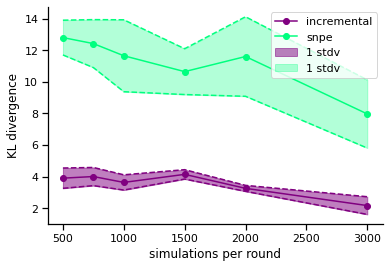

In [19]:
sns.set_context('notebook')
#sns.set_context('talk')

plt.plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='purple')
plt.plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='springgreen')

plt.plot(num_simulations_list, upper_incremental, '--', color='purple')
plt.plot(num_simulations_list, upper_snpe, '--',  color='springgreen')

plt.plot(num_simulations_list, lower_incremental, '--',  color='purple')
plt.plot(num_simulations_list, lower_snpe, '--',  color='springgreen')


plt.fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='purple', alpha=0.5,  label='1 stdv')
plt.fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='springgreen', alpha=0.3, label='1 stdv')


plt.legend()



plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

sns.despine()
sns.despine()

